In [1]:
# создание файла c predict закомментированы у двух моделей. При надобности можно раскомментировать

In [116]:
# добавить из уроков
import torch
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_fscore_support,make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# !pip install imblearn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

### Обобщение работы с новой задачей 
1. Получить базовое решение
    * Минимально познакомиться с данными
    * Заполнить пропуски простым методом (нулями, медиана, среднее, мода...)
    * Обучить простую модель (линейная, деревья...)
    * Посчитать метрику качества
2. EDA
    * Изучить целевую переменную 
        * регрессия - распределение, меры центральной тенденции
        * классификация - баланс классов
    * Изучить признаки
        * корреляция
        * найти проблемные признаки
        * найти пропуски
        * найти выбросы
        * сгенерировать идеи по их заполнению
    * Изучить влияние признаков на целевую переменную
        * корреляция
        * классификация - разделение значений в зависимости от классов
    * Постоянно придумывать идеи для новых признаков (где-то их фиксировать)
3. Предобработка данных**
    * Разделить данные на train и test
    * Зависит от выбранной модели
        * Масштабирование
    * Заполнить пропуски
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Обработать выбросы
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Генерация новых признаков
        1. Категориальные признаки
            a. pd.get_dummies, OneHotEncoder
            b. Feature Encoding
            c. Target Encoding
        2. Вещественные признаки
            a. Feature discretization
            b. Feature binarization
    * Оформить предобработку в класс/функции для воспроизводимости
4. Обучение и валидация моделей
    * Обучить модель на базовых гиперпараметрах
    * Вручную настраивать гиперпарметры
    * Автоматизированный выбор гиперпараметров с кросс-валидацией GridSearchCV/RandomSearchCV
    * Следить за переобучением, если оно появляется, то искать лучший параматер регуляризации
    * Посчитать метрики
5. Воспроизводимость
    * Зафиксировать результаты эксперимента
    * Сохранить модели
    * Сохранить версии библиотек
6. Вы и ваша модель идеальна! :)

In [4]:
course_proj_train = pd.read_csv('course_project_train.csv')
course_proj_test = pd.read_csv('course_project_test.csv')

In [5]:
# c Kaggle датасеты
# course_proj_train = pd.read_csv('train.csv')
# course_proj_test = pd.read_csv('test.csv')

### Целевая переменная в train

In [6]:
train_target = course_proj_train['Credit Default']

<AxesSubplot:>

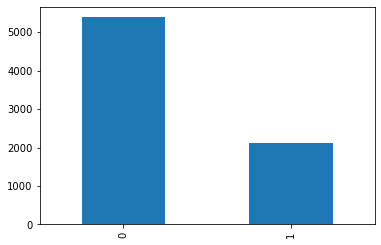

In [7]:
train_target.value_counts().plot.bar()

In [8]:
train_target.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [9]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [10]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    t = precision_recall_fscore_support(y_train_true, y_train_pred, average='binary')
    te = precision_recall_fscore_support(y_test_true, y_test_pred, average='binary')
    print(t)
    print(te)
    print('TRAIN f1 1')
    print(f1_score(y_train_true, y_train_pred, average='binary'))
    print('TEST f1 1')
    print(f1_score(y_test_true, y_test_pred, average='binary'))

In [12]:
def display_func(X):
    return display(X.info(), X.describe(), X.isna().sum())

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col, mod):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.30,
                                                        shuffle=True,
                                                        random_state=9)
    if mod == 'regr':
        model = RandomForestRegressor(n_estimators=100,
                                  max_depth=5,
                                  random_state=9,
                                  verbose=1)
        model.fit(X_train, y_train)
    
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
    
        print(f"r2 на train: {r2_score(y_train, pred_train)}")
        print(f"r2 на test: {r2_score(y_test, pred_test)}")
 
    elif mod == 'class':
        model = lgbm.LGBMClassifier(random_state=9)
        
        model.fit(X_train, y_train)
    
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
    
        print(f"f1_score на train: {f1_score(y_train, pred_train, average='weighted')}")
        print(f"f1_score на test: {f1_score(y_test, pred_test, average='weighted')}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [14]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [15]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [16]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Info, Describe, Isna ----> Train

In [17]:
display_func(course_proj_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

None

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Info, Describe, Isna ----> Test

In [18]:
display_func(course_proj_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

None

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Построим тепловую карту корреляций

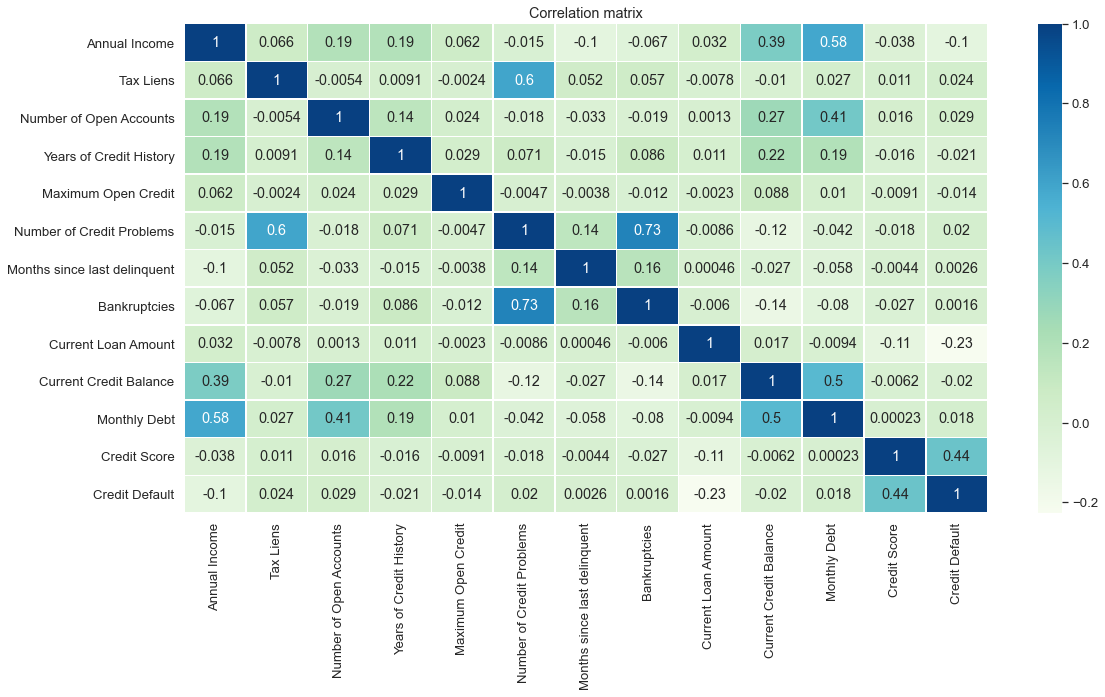

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
# на scaled значения
plt.figure(figsize = (18,9))

sns.set(font_scale=1.2)
sns.heatmap(course_proj_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# посмотреть после перевода категориальных в dummie

### Заполнение пропущенные значения

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

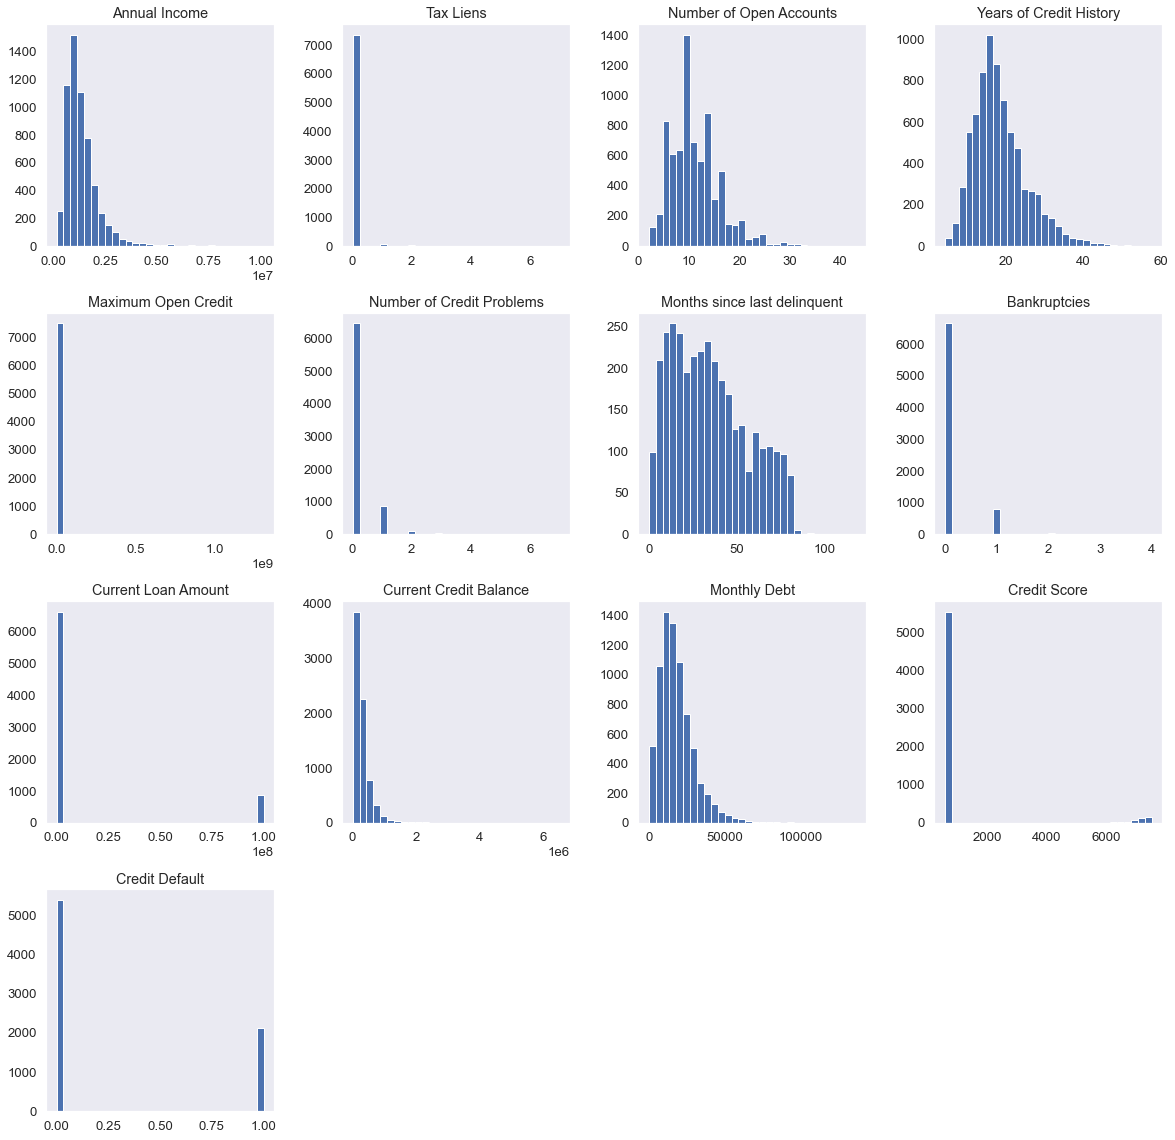

In [20]:
course_proj_train.hist(figsize=(20,20), bins=30, grid=False)

In [21]:
# обработааем выбросы

In [22]:
feature_name = 'Credit Score'
course_proj_train = preprocess_outlier(course_proj_train, feature_name, threshold=1200)
course_proj_test = preprocess_outlier(course_proj_test, feature_name, threshold=1200)

course_proj_train[feature_name].isna().sum()

1957

In [23]:
feature_name = 'Current Loan Amount'
course_proj_train = preprocess_outlier(course_proj_train, feature_name, threshold=1000000)
course_proj_test = preprocess_outlier(course_proj_test, feature_name, threshold=1000000)

course_proj_train.loc[course_proj_train['Current Loan Amount'].isna(), 'Current Loan Amount'] = course_proj_train['Current Loan Amount'].median()
course_proj_test.loc[course_proj_test['Current Loan Amount'].isna(), 'Current Loan Amount'] = course_proj_train['Current Loan Amount'].median()
course_proj_train[feature_name].isna().sum()

0

In [24]:
# в Months since last delinquent пропущено более половины значений, его уберем

In [25]:
course_proj_train = course_proj_train.drop(['Months since last delinquent'], axis=1)
course_proj_test = course_proj_test.drop(['Months since last delinquent'], axis=1)

In [26]:
# Years in current job заолпняем модой

In [27]:
course_proj_train['Years in current job'].value_counts().head(10)

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
Name: Years in current job, dtype: int64

In [28]:
course_proj_train.loc[course_proj_train['Years in current job'].isna(), 'Years in current job'] = course_proj_train['Years in current job'].mode()[0]
course_proj_test.loc[course_proj_test['Years in current job'].isna(), 'Years in current job'] = course_proj_train['Years in current job'].mode()[0]

In [29]:
# заполним пропущенные Bankruptcies

In [30]:
course_proj_train.loc[course_proj_train['Bankruptcies'].isna(), 'Bankruptcies'] = course_proj_train['Bankruptcies'].mode()[0]
course_proj_test.loc[course_proj_test['Bankruptcies'].isna(), 'Bankruptcies'] = course_proj_train['Bankruptcies'].mode()[0]

In [31]:
df_copy_ = course_proj_train.drop(['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Annual Income'], axis=1).copy()

In [32]:
# Ни Credit Score ни Annual Income моделью заполнить не получилось, очень низкий скор. Заполним их средними значениями.

In [33]:
course_proj_train['Credit Score'].mean()

720.7059354140357

In [34]:
course_proj_train['Credit Score'].value_counts()

740.0    169
747.0    168
748.0    157
745.0    152
742.0    151
        ... 
609.0      1
606.0      1
610.0      1
593.0      1
620.0      1
Name: Credit Score, Length: 158, dtype: int64

In [35]:
course_proj_train.loc[course_proj_train['Credit Score'].isna(), 'Credit Score'] = course_proj_train['Credit Score'].mean()
course_proj_test.loc[course_proj_test['Credit Score'].isna(), 'Credit Score'] = course_proj_train['Credit Score'].mean()

In [36]:
course_proj_train['Annual Income'].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

In [37]:
course_proj_train['Annual Income'].mean()

1366391.7201749957

In [38]:
course_proj_train.loc[course_proj_train['Annual Income'].isna(), 'Annual Income'] = course_proj_train['Annual Income'].mean()
course_proj_test.loc[course_proj_test['Annual Income'].isna(), 'Annual Income'] = course_proj_train['Annual Income'].mean()

In [39]:
display(course_proj_train.isna().sum(), course_proj_test.isna().sum(), course_proj_train.shape, course_proj_test.shape)

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

(7500, 16)

(2500, 15)

### Сделаем копию датасетов для второй модели

In [40]:
course_proj_train_2 = course_proj_train.copy()
course_proj_test_2 = course_proj_test.copy()

### Посмотрим категориальные признаки, сколько будет дополнительных признаков

In [41]:
for cat_colname in course_proj_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(course_proj_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Dummies

In [42]:
# переведем категориальные признаки в dummie

In [43]:
train_dummies = course_proj_train.select_dtypes(include='object')
test_dummies = course_proj_test.select_dtypes(include='object')

In [44]:
train_dummies.columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [45]:
test_dummies.columns

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [46]:
train_dummies = pd.get_dummies(train_dummies)
test_dummies = pd.get_dummies(test_dummies)

In [47]:
train_dummies = train_dummies.drop(['Purpose_renewable energy'], axis = 1) # в тесте его нет

In [48]:
test_dummies.shape

(2500, 31)

In [49]:
train_dummies.shape

(7500, 31)

In [50]:
# удалим object признаки из нашего датасета

In [51]:
course_proj_train = course_proj_train.drop(course_proj_train.select_dtypes(include='object'), axis=1)
course_proj_test = course_proj_test.drop(course_proj_test.select_dtypes(include='object'), axis=1)

In [52]:
course_proj_train = pd.concat([train_dummies, course_proj_train], axis=1)

In [53]:
course_proj_test = pd.concat([test_dummies, course_proj_test], axis=1)

In [54]:
course_proj_train.shape

(7500, 43)

In [55]:
course_proj_test.shape

(2500, 42)

### Балансировка классов

In [56]:
balance = course_proj_train.select_dtypes(include=['float64', 'int64'])

In [57]:
course_proj_train = course_proj_train.drop(course_proj_train.select_dtypes(include=['float64', 'int64']), axis=1)

In [58]:
disbalance = train_target.value_counts()[0] / train_target.value_counts()[1]
disbalance

2.549455750118315

In [59]:
df_balanced = balance_df_by_target(balance, 'Credit Default', method='smote')

df_balanced['Credit Default'].value_counts()

1    5387
0    5387
Name: Credit Default, dtype: int64

In [60]:
df_balanced_ = pd.concat([course_proj_train, balance], axis=1)

In [61]:
df_balanced_

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,0,1,0,0,1,0,0,0,0,...,11.0,26.3,685960.0,1.0,1.0,265826.0,47386.0,7914.0,749.000000,0
1,0,0,1,0,0,1,0,0,0,0,...,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,18373.0,737.000000,1
2,0,1,0,0,0,0,0,0,0,0,...,11.0,35.0,1182434.0,0.0,0.0,265826.0,308389.0,13651.0,742.000000,0
3,0,0,1,0,0,0,0,0,0,0,...,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,11338.0,694.000000,0
4,0,0,0,1,0,0,0,0,0,0,...,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,7180.0,719.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,1,0,0,0,0,0,0,...,3.0,8.5,107866.0,0.0,0.0,129360.0,73492.0,1900.0,697.000000,0
7496,0,1,0,0,1,0,0,0,0,0,...,10.0,26.5,686312.0,0.0,0.0,444048.0,456399.0,12783.0,720.705935,1
7497,0,0,0,1,0,0,0,0,0,0,...,12.0,32.1,1778920.0,0.0,0.0,265826.0,477812.0,12479.0,748.000000,0
7498,0,1,0,0,0,1,0,0,0,0,...,21.0,26.5,1141250.0,0.0,0.0,615274.0,476064.0,37118.0,720.705935,0


In [62]:
df_balanced_.isna().sum()

Home Ownership_Have Mortgage      0
Home Ownership_Home Mortgage      0
Home Ownership_Own Home           0
Home Ownership_Rent               0
Years in current job_1 year       0
Years in current job_10+ years    0
Years in current job_2 years      0
Years in current job_3 years      0
Years in current job_4 years      0
Years in current job_5 years      0
Years in current job_6 years      0
Years in current job_7 years      0
Years in current job_8 years      0
Years in current job_9 years      0
Years in current job_< 1 year     0
Purpose_business loan             0
Purpose_buy a car                 0
Purpose_buy house                 0
Purpose_debt consolidation        0
Purpose_educational expenses      0
Purpose_home improvements         0
Purpose_major purchase            0
Purpose_medical bills             0
Purpose_moving                    0
Purpose_other                     0
Purpose_small business            0
Purpose_take a trip               0
Purpose_vacation            

### Удаляем целевую переменную из train датасета

In [63]:
train_target_ = df_balanced['Credit Default']

In [64]:
train_data_ = df_balanced_.drop(['Credit Default'], axis=1)

In [65]:
train_data_

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,0,1,0,0,1,0,0,0,0,...,0.0,11.0,26.3,685960.0,1.0,1.0,265826.0,47386.0,7914.0,749.000000
1,0,0,1,0,0,1,0,0,0,0,...,0.0,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,18373.0,737.000000
2,0,1,0,0,0,0,0,0,0,0,...,0.0,11.0,35.0,1182434.0,0.0,0.0,265826.0,308389.0,13651.0,742.000000
3,0,0,1,0,0,0,0,0,0,0,...,0.0,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,11338.0,694.000000
4,0,0,0,1,0,0,0,0,0,0,...,0.0,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,7180.0,719.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,1,0,0,0,0,0,0,...,0.0,3.0,8.5,107866.0,0.0,0.0,129360.0,73492.0,1900.0,697.000000
7496,0,1,0,0,1,0,0,0,0,0,...,0.0,10.0,26.5,686312.0,0.0,0.0,444048.0,456399.0,12783.0,720.705935
7497,0,0,0,1,0,0,0,0,0,0,...,0.0,12.0,32.1,1778920.0,0.0,0.0,265826.0,477812.0,12479.0,748.000000
7498,0,1,0,0,0,1,0,0,0,0,...,0.0,21.0,26.5,1141250.0,0.0,0.0,615274.0,476064.0,37118.0,720.705935


### Проведем стандартизацию

In [66]:
test_columns = course_proj_test.columns
test_columns

Index(['Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_small business', 'Purpose_take a trip',
       'Purpose_vacation', 'Purpose_wedding', 'Term_Long Term',
       'Term_Short Term', 'Annual Income', 'Tax Liens',
       'Number of Open Accounts', '

In [67]:
train_columns = train_data_.columns
train_columns

Index(['Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_small business', 'Purpose_take a trip',
       'Purpose_vacation', 'Purpose_wedding', 'Term_Long Term',
       'Term_Short Term', 'Annual Income', 'Tax Liens',
       'Number of Open Accounts', '

In [68]:
train_data_ = preprocessing.scale(train_data_)

In [69]:
test_data_ = preprocessing.scale(course_proj_test)

In [70]:
train_data_ = pd.DataFrame(train_data_, columns=train_columns)

In [71]:
test_data_ = pd.DataFrame(test_data_, columns=test_columns)

In [72]:
train_data_.head(3)

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,-0.040032,-0.970307,3.254530,-0.863603,-0.268405,1.332177,-0.322107,-0.300194,-0.258272,-0.271815,...,-0.110953,-0.026674,1.133645,-0.016174,1.664779,2.545732,-0.222098,-0.762772,-0.872085,1.190364
1,-0.040032,-0.970307,3.254530,-0.863603,-0.268405,1.332177,-0.322107,-0.300194,-0.258272,-0.271815,...,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.337099,-0.227088,0.330781,0.004909,0.685510
2,-0.040032,1.030601,-0.307264,-0.863603,-0.268405,-0.750651,-0.322107,-0.300194,-0.258272,-0.271815,...,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.337099,-0.222098,0.058379,-0.391034,0.895866


In [73]:
test_data_.head(3)

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,-0.052989,-0.980196,-0.33185,1.204566,-0.255323,-0.747398,-0.304397,-0.316784,3.930314,-0.26926,...,-0.091141,-0.450224,-0.803220,-0.323879,-0.289398,-0.299225,-0.841489,-0.503642,-0.992788,0.011866
1,-0.052989,-0.980196,-0.33185,1.204566,3.916615,-0.747398,-0.304397,-0.316784,-0.254433,-0.26926,...,-0.091141,-1.068551,1.981755,-0.433044,-0.289398,-0.299225,-1.330544,-0.661931,-1.382250,-0.914947
2,-0.052989,1.020204,-0.33185,-0.830174,-0.255323,-0.747398,-0.304397,3.156725,-0.254433,-0.26926,...,-0.091141,-0.244115,-0.637776,-0.334707,-0.289398,-0.299225,-0.622398,-0.396341,0.039653,0.011866


### Разделим train датасет для обучения и тестирования модели

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_data_, 
    train_target, 
    test_size=0.3,
    random_state=9)#, 
    #shuffle=True)

In [75]:
X_train.shape

(5250, 42)

In [76]:
X_test.shape

(2250, 42)

In [77]:
X_train.rename(columns={'Years in current job_< 1 year': 'Years in current less_1 year'}, inplace=True)

In [78]:
X_test.rename(columns={'Years in current job_< 1 year': 'Years in current less_1 year'}, inplace=True)

In [79]:
test_data_.rename(columns={'Years in current job_< 1 year': 'Years in current less_1 year'}, inplace=True)

### XGBoost

In [80]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=3, 
                              )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[22:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      3772
           1       0.92      0.49      0.64      1478

    accuracy                           0.84      5250
   macro avg       0.87      0.73      0.77      5250
weighted avg       0.85      0.84      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1615
           1       0.72      0.33      0.45       635

    accuracy                           0.77      2250
   macro avg       0.75      0.64      0.66      2250
weighted avg       0.76      0.77      0.74      2250

CONFUSION MATRIX

col_0

In [81]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [82]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [83]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)
display(grid_search.best_params_, grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] reg_lambda=0.2 ..................................................
[22:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.2, total=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] reg_lambda=0.2 ..................................................
[22:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.2, total=   0.2s
[CV] reg_lambda=0.2 ..................................................
[22:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.2, total=   0.2s
[CV] reg_lambda=0.5 ..................................................
[22:50:50] WARNING: C:/Us

[CV] reg_lambda=5 ....................................................
[22:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ..................................... reg_lambda=5, total=   0.2s
[CV] reg_lambda=10 ...................................................
[22:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] .................................... reg_lambda=10, total=   0.2s
[CV] reg_lambda=10 ...................................................
[22:50:54] WARNING: C:/Us

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.9s finished


[22:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'reg_lambda': 3}

0.46450303769470674

Wall time: 5.23 s


In [84]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=3,
                              reg_lambda=3
                              )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[22:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3772
           1       0.89      0.47      0.61      1478

    accuracy                           0.83      5250
   macro avg       0.86      0.72      0.75      5250
weighted avg       0.84      0.83      0.81      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1615
           1       0.72      0.31      0.43       635

    accuracy                           0.77      2250
   macro avg       0.75      0.63      0.64      2250
weighted avg       0.76      0.77      0.74      2250

CONFUSION MATRIX

col_0

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

In [85]:
y_test_pred_test = model_xgb.predict_proba(X_test)

In [86]:
import inspect
print(inspect.getsource(show_proba_calibration_plots))

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, labe

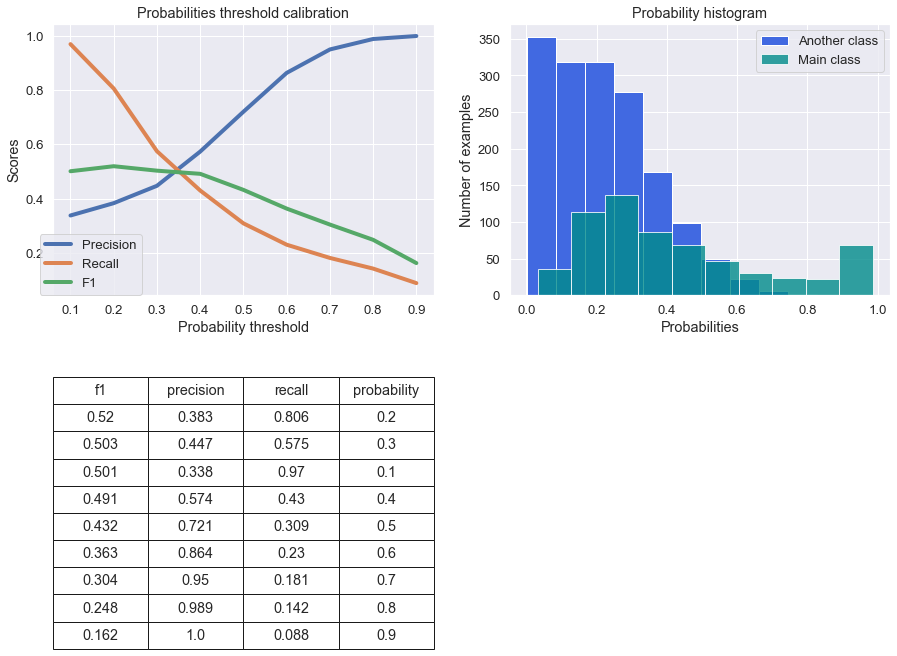

In [87]:
show_proba_calibration_plots(y_test_pred_test[:, 1], y_test)

In [88]:
y_test_pred = model_xgb.predict_proba(test_data_)

In [89]:
y_test_pred.shape[0]

2500

In [90]:
def calc_pred(x):
    x = [0 if x <= 0.2 else 1 for x in  x]
    return np.array(x)

In [91]:
y_test_pred_ = calc_pred(y_test_pred[:, 1])
y_test_pred_

array([1, 1, 1, ..., 1, 0, 1])

In [92]:
y_test_pred = pd.DataFrame(data=y_test_pred_, columns=['Credit Default'], index=None)

In [93]:
y_test_pred.insert(0, 'Id', np.arange(0,y_test_pred.shape[0]))

In [94]:
y_test_pred['Credit Default'].value_counts()

1    1469
0    1031
Name: Credit Default, dtype: int64

In [95]:
#y_test_pred.to_csv('submission.csv', index=False)

### Важность признаков<a class="anchor" id="feature_importances"></a>

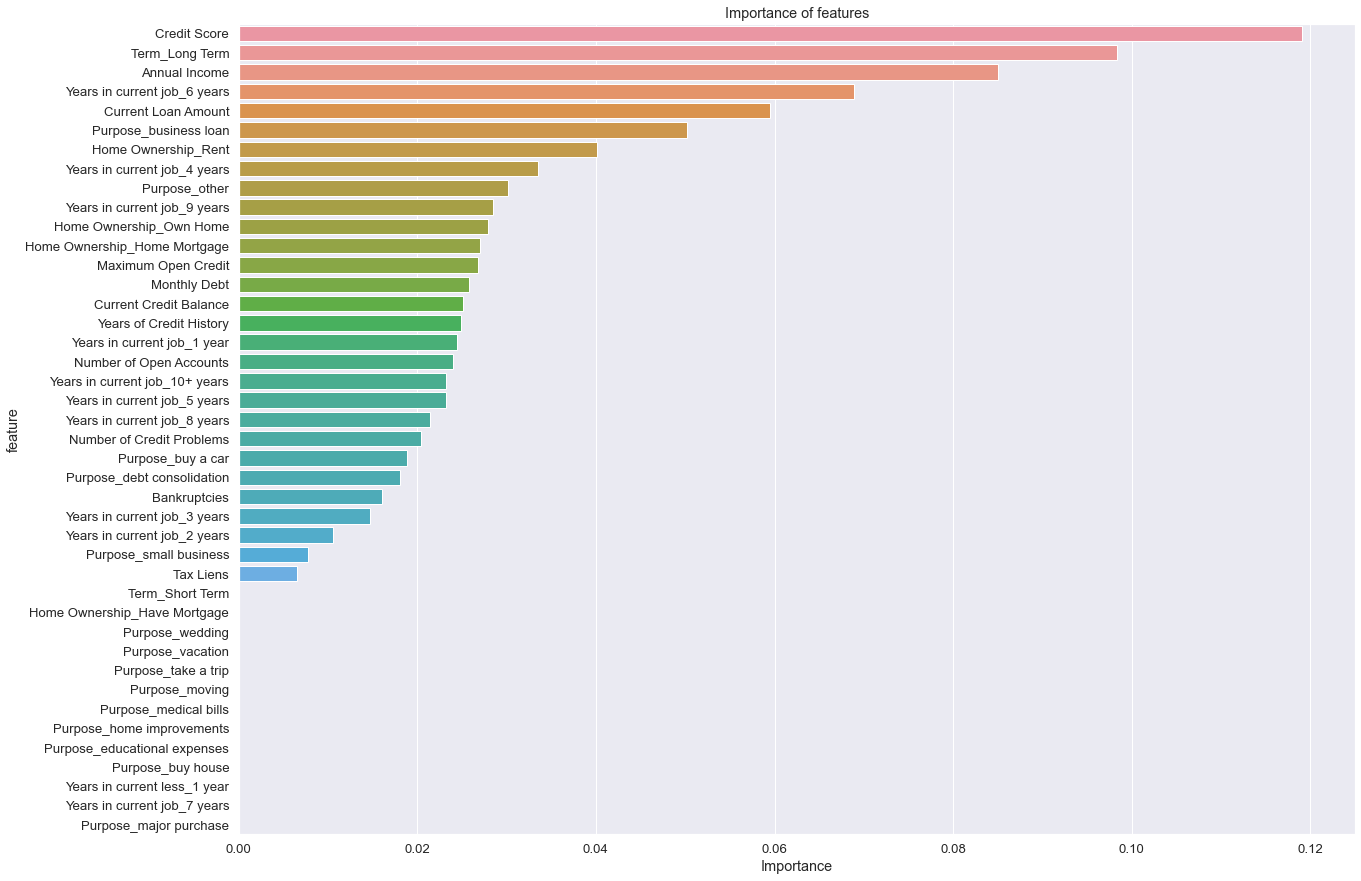

In [96]:
important_features_top = show_feature_importances(X_train.columns, model_xgb.feature_importances_, get_top=20)

### Данная модель показала результат: 0.46938 на Kaggle

### Вторая модель CatBoost

In [97]:
train_target = course_proj_train_2['Credit Default']

In [98]:
course_proj_train_2 = course_proj_train_2.drop(['Credit Default'], axis=1)

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    course_proj_train_2, 
    train_target, 
    test_size=0.3,
    random_state=9)#, 
    #shuffle=True)

In [100]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [101]:
disbalance

2.549455750118315

In [102]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [103]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=3)#,reg_lambda=0.005)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.59      0.70      3772
           1       0.41      0.74      0.53      1478

    accuracy                           0.63      5250
   macro avg       0.63      0.67      0.61      5250
weighted avg       0.73      0.63      0.65      5250

TEST

              precision    recall  f1-score   support

           0       0.86      0.58      0.69      1615
           1       0.42      0.77      0.54       635

    accuracy                           0.63      2250
   macro avg       0.64      0.67      0.62      2250
weighted avg       0.74      0.63      0.65      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               929  686
1               145  490
(0.41402714932126694, 0.7428958051420839, 0.5317191283292978, None)
(0.4166666666666667, 0.7716535433070866, 0.5411374930977361, None)
TRAIN f1 1
0.5317191283292978
TEST f1 1
0.5411374930977361
Wall time: 689 ms


In [104]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [105]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [106]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [107]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.661749262
bestIteration = 33

0:	loss: 0.6617493	best: 0.6617493 (0)	total: 415ms	remaining: 5.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6559138018
bestIteration = 1

1:	loss: 0.6559138	best: 0.6617493 (0)	total: 570ms	remaining: 3.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6559138018
bestIteration = 1

2:	loss: 0.6559138	best: 0.6617493 (0)	total: 744ms	remaining: 2.97s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6559138018
bestIteration = 1

3:	loss: 0.6559138	best: 0.6617493 (0)	total: 927ms	remaining: 2.55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6559138018
bestIteration = 1

4:	loss: 0.6559138	best: 0.6617493 (0)	total: 1.1s	remaining: 2.21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6565578443
bestIteration = 19

5:	loss: 0.6565578	best: 0.6617493 (0)	total: 1.57s	remaining: 2.35s
Stopped by overfitting detector  (20 iterations wait)


In [108]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
3,3,0.671378,0.006961,0.674195,0.004278,0.684612,0.000332,0.683894,0.000652
5,5,0.670779,0.003428,0.673941,0.005670,0.680512,0.000771,0.679527,0.000327
18,18,0.670620,0.009506,0.670786,0.005308,0.661305,0.003920,0.658428,0.003371
19,19,0.670313,0.008503,0.670579,0.004952,0.660292,0.004124,0.657385,0.003497
22,22,0.670156,0.007765,0.671799,0.005797,0.657284,0.003772,0.654009,0.003173


In [109]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=50, max_depth=3)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.59      0.70      3772
           1       0.42      0.77      0.55      1478

    accuracy                           0.64      5250
   macro avg       0.65      0.68      0.62      5250
weighted avg       0.74      0.64      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.58      0.70      1615
           1       0.42      0.78      0.55       635

    accuracy                           0.64      2250
   macro avg       0.65      0.68      0.62      2250
weighted avg       0.74      0.64      0.65      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               937  678
1               139  496
(0.4225352112676056, 0.7713125845737483, 0.5459770114942528, None)
(0.42248722316865417, 0.7811023622047244, 0.5483692647871752, None)
TRAIN f1 1
0.5459770114942528
TEST f1 1
0.5483692647871752
Wall time: 442 ms


In [110]:
y_test_pred_2 = model_catb.predict(course_proj_test_2)

In [111]:
y_test_pred_2 = pd.DataFrame(data=y_test_pred_2, columns=['Credit Default'], index=None)

In [112]:
y_test_pred_2.insert(0, 'Id', np.arange(0,y_test_pred_2.shape[0]))

In [113]:
y_test_pred_2

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,0
2498,2498,0


In [114]:
y_test_pred_2['Credit Default'].value_counts()

0    1359
1    1141
Name: Credit Default, dtype: int64

In [115]:
#y_test_pred_2.to_csv('submission_2.csv', index=False)

### Данная модель показала наилучший результат 0.53793

Что не так с XGBoost? Или просто не очень подходит для данной задачи? На XGBoost потратил целый день, на CatBoost 30 минут. Как можно было улучшить XGBoost с учетом того, что создавать новые признаки мы еще не умеем?